# Ranking Stocks with Signals in 2008

## Project Goal

The goal of this project was to see if stock signals could help pick better-performing stocks during a hard year like 2008.

I tested three signals from the Open Asset Pricing dataset:
- **AM** (Asset Growth Minus Accruals): Measures how fast a company’s assets are growing. Lower growth is usually better.
- **AOP** (Accruals Over Price): Looks at how much of a company’s earnings come from non-cash items. Lower values are often better.
- **AnalystRevision**: Based on changes in analysts' forecasts.


## Data Used

- **signal2008_sample.csv** – monthly signal values for a sample of stocks in 2008  
- **crsp_2008_2023_rets.csv** – monthly stock returns from 2008–2023  
I combined both datasets using stock ID and month to compare signal scores to real returns.

In [7]:
# Set up 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import urllib.request

## Step 1: Load and Preview 2008 Signal Sample Data

load the signal2008_sample.csv file to preview the structure of the dataset and inspect what signals are available. This helps me choose which ones I want to analyze in more detail.

In [8]:
url = 'https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/signal2008_sample.csv'

df_2008 = pd.read_csv(url)
df_2008.head()

,permno,yyyymm,AM,AOP,Accruals,AccrualsBM,Activism1,Activism2,AgeIPO,AnalystRevision,...,realestate,retConglomerate,roaq,sfe,skew1,std_turn,tang,zerotrade,zerotradeAlt12,date
0,10032,200801,0.763326,0.52434,-0.014848,NaN,NaN,NaN,NaN,0.994737,...,NaN,NaN,0.029746,NaN,-0.056691,NaN,0.785901,8.105539e-09,7.338935e-09,2008-01-31
1,10032,200802,0.695966,0.52434,-0.014848,NaN,NaN,NaN,NaN,0.994709,...,NaN,NaN,0.029746,NaN,-0.048161,NaN,0.785901,8.819205e-09,7.487527e-09,2008-02-29
2,10032,200803,0.748897,0.52434,-0.032580,NaN,NaN,NaN,NaN,1.021277,...,NaN,NaN,0.029770,NaN,-0.058780,NaN,0.774756,8.235955e-09,7.822338e-09,2008-03-31
3,10032,200804,0.872003,0.52434,-0.032580,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,0.029770,NaN,-0.037279,NaN,0.774756,7.870446e-09,8.027040e-09,2008-04-30
4,10032,200805,0.765690,0.52434,-0.032580,NaN,NaN,NaN,NaN,0.973958,...,NaN,NaN,0.029770,NaN,NaN,NaN,0.774756,8.003802e-09,7.926766e-09,2008-05-31


## Step 2: Pick Clean Signals and Rank Stocks
 In this step, I will rank stocks by each signal within each month to prepare for analyzing their return performance.

In [9]:
df_ranked = df_2008.copy()

# List of signals to rank
signals_to_rank = ['AM', 'AOP', 'AnalystRevision']

# Rank each stock by signal within each month (higher = better rank)
for signal in signals_to_rank:
    df_ranked[f'{signal}_rank'] = df_ranked.groupby('yyyymm')[signal].rank(method='first', ascending=False)

df_ranked[['permno', 'yyyymm'] + signals_to_rank + [f'{s}_rank' for s in signals_to_rank]].head()

,permno,yyyymm,AM,AOP,AnalystRevision,AM_rank,AOP_rank,AnalystRevision_rank
0,10032,200801,0.763326,0.52434,0.994737,40.0,1.0,44.0
1,10032,200802,0.695966,0.52434,0.994709,42.0,1.0,40.0
2,10032,200803,0.748897,0.52434,1.021277,38.0,1.0,16.0
3,10032,200804,0.872003,0.52434,1.000000,37.0,1.0,10.0
4,10032,200805,0.765690,0.52434,0.973958,39.0,1.0,35.0


## Step 3: Rank Stocks Within Each Month by Signal

I ranked stocks by each selected signal within each month using groupby and rank. 
This will allow me to later compare the performance of top-ranked vs. bottom-ranked stocks.

In [25]:
# Make a full copy of the sliced DataFrame to avoid the warning
am_2008 = signals_2008[['permno', 'month', 'AM']].copy()

# Now rank and create quantiles safely
am_2008['am_rank'] = am_2008.groupby('month')['AM'].rank(method='first')
am_2008['am_quantile'] = am_2008.groupby('month')['am_rank'].transform(
    lambda x: pd.qcut(x, 5, labels=False, duplicates='drop')
) + 1

## Step 4: Bringing in Return Data to Test Signal Effectiveness

Now that I’ve ranked stocks by their signal values each month, I will import monthly stock return data from 2008–2023, merge this data with my ranked signal dataset using permno and yyyymm, and analyze how stocks ranked highly on each signal performed in the following month.

This step will help determine whether these signals have any predictive power for returns

In [12]:
rets_url = 'https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/refs/heads/main/data/crsp_2008_2023_ret.csv'
df_rets = pd.read_csv(rets_url)

df_rets.head()

,PERMNO,date,TICKER,RET
0,10001,2008-01-31,EWST,-0.006082
1,10001,2008-02-29,EWST,0.021704
2,10001,2008-03-31,EWST,-0.052516
3,10001,2008-04-30,EWST,-0.036698
4,10001,2008-05-30,EWST,0.271628


## Step 5: Merge Ranked Signals with Return Data

In this step, I merge my ranked signal data with actual stock return data using permno and date. This allows me to test whether the stocks that ranked highly on a given signal actually went on to perform better (or worse) in that month.

In [ ]:
#Convert yyyymm to proper date format (end of month)
df_ranked['date'] = pd.to_datetime(df_ranked['yyyymm'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)

#  Make sure return data has datetime too
df_rets.rename(columns={'PERMNO': 'permno'}, inplace=True)
df_rets['date'] = pd.to_datetime(df_rets['date']) 

df_merged = pd.merge(df_ranked, df_rets, on=['permno', 'date'], how='inner')

df_merged[['permno', 'date', 'RET', 'AM_rank', 'AOP_rank', 'AnalystRevision_rank']].head()


,permno,date,RET,AM_rank,AOP_rank,AnalystRevision_rank
0,10032,2008-01-31,-0.139756,40.0,1.0,44.0
1,10032,2008-02-29,0.096503,42.0,1.0,40.0
2,10032,2008-03-31,0.132418,38.0,1.0,16.0
3,10032,2008-04-30,-0.141176,37.0,1.0,10.0
4,10032,2008-06-30,-0.019483,42.0,16.0,12.0


## Step 6: Compare Returns for High vs. Low Ranked Stocks

Now that I’ve ranked the stocks, I want to see if the ones with better signal scores actually made more money.

I split the stocks into 5 groups based on their signal rank each month:
- Group 5 = top 20% (highest ranked)
- Group 1 = bottom 20% (lowest ranked)

Then I check the average return for each group. **If Group 5 has higher returns than Group 1, it means the signal might be useful.**


In [13]:
# Make sure return column is numeric
df_merged['RET'] = pd.to_numeric(df_merged['RET'], errors='coerce')

# Define a function to label stocks by signal rank quantile
def label_quantiles(x):
    return pd.qcut(x, q=5, labels=[1, 2, 3, 4, 5])  

# Apply to AM rank
df_merged['AM_quantile'] = df_merged.groupby('date')['AM_rank'].transform(label_quantiles)

# Calculate average return
am_return_by_quantile = df_merged.groupby('AM_quantile')['RET'].mean()

# Display the result
print("Average Return by AM Signal Quantile:")
print(am_return_by_quantile)

Average Return by AM Signal Quantile:
AM_quantile
1   -0.050320
2   -0.089315
3   -0.041581
4   -0.044424
5    0.000006
Name: RET, dtype: float64


/tmp/ipykernel_19312/3421631434.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  am_return_by_quantile = df_merged.groupby('AM_quantile')['RET'].mean()


### What the Results Show (AM Signal)

These results show how stocks did based on their AM score. Group 5 had the highest scores, and Group 1 had the lowest.

In 2008, the higher-scoring stocks lost less money. This means the AM signal may have helped find stronger stocks during a bad year.

In [14]:
# For AOP
df_merged['AOP_quantile'] = df_merged.groupby('date')['AOP_rank'].transform(label_quantiles)
aop_return_by_quantile = df_merged.groupby('AOP_quantile')['RET'].mean()
print("Average Return by AOP Signal Quantile:")
print(aop_return_by_quantile)

Average Return by AOP Signal Quantile:
AOP_quantile
1   -0.061840
2   -0.018705
3   -0.043498
4   -0.084367
5   -0.035663
Name: RET, dtype: float64


/tmp/ipykernel_19312/888219367.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aop_return_by_quantile = df_merged.groupby('AOP_quantile')['RET'].mean()


### What the Results Show (AOP Signal)

These results show how stocks did based on their AOP score. But unlike the AM signal, there’s no clear pattern.

Group 2 actually lost the least, and Group 4 did the worst. So in 2008, the AOP signal didn’t seem very helpful for picking better stocks.

In [15]:
# For AnalystRevision
df_merged['AnalystRevision_quantile'] = df_merged.groupby('date')['AnalystRevision_rank'].transform(label_quantiles)
rev_return_by_quantile = df_merged.groupby('AnalystRevision_quantile')['RET'].mean()
print("Average Return by AnalystRevision Signal Quantile:")
print(rev_return_by_quantile)

Average Return by AnalystRevision Signal Quantile:
AnalystRevision_quantile
1   -0.039708
2   -0.018766
3   -0.053868
4   -0.040077
5   -0.079250
Name: RET, dtype: float64


/tmp/ipykernel_19312/3117742473.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rev_return_by_quantile = df_merged.groupby('AnalystRevision_quantile')['RET'].mean()


### What the Results Show (AnalystRevision Signal)

These results are based on the AnalystRevision signal. The pattern isn’t clear here either.

The highest-ranked stocks did the worst, and Group 2 did the best. So this signal didn’t work well in 2008 and may have pointed in the wrong direction.


## Step 7: Visualize the Results

To make my analysis easier to understand, I created bar charts showing the average return for each group (quantile) based on signal rank.

If the signal is useful, we would expect higher-ranked groups (especially Quantile 5) to show better performance.


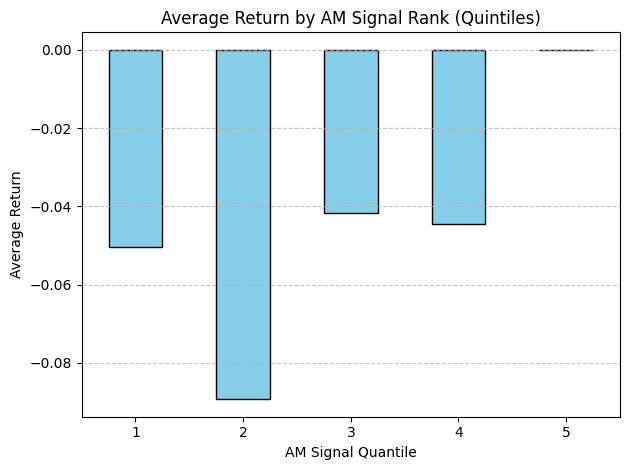

In [16]:
# Plot for AM Signal
am_return_by_quantile.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Return by AM Signal Rank (Quintiles)')
plt.xlabel('AM Signal Quantile')
plt.ylabel('Average Return')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### AOP Signal Performance

This chart shows the average return for each AOP signal rank group. The pattern is inconsistent, and there is no clear relationship between rank and return.

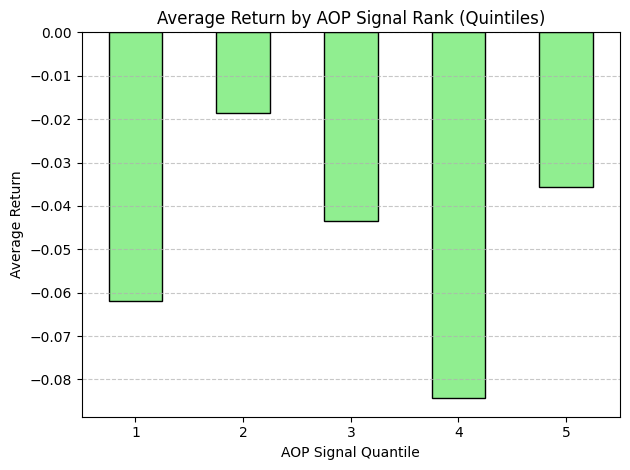

In [17]:
aop_return_by_quantile.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Average Return by AOP Signal Rank (Quintiles)')
plt.xlabel('AOP Signal Quantile')
plt.ylabel('Average Return')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### AnalystRevision Signal Performance

This chart shows the average return for each AnalystRevision rank group. Interestingly, the highest-ranked group performed the worst, suggesting this signal did not work well in 2008.

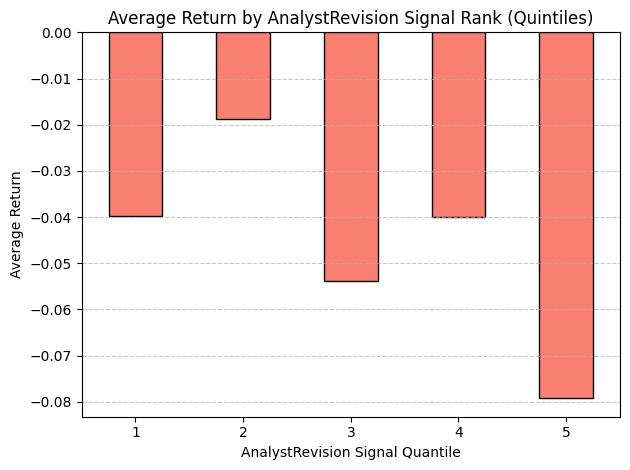

In [18]:
# show
rev_return_by_quantile.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Average Return by AnalystRevision Signal Rank (Quintiles)')
plt.xlabel('AnalystRevision Signal Quantile')
plt.ylabel('Average Return')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Step 8: Filter for Large Cap Stocks (Market Cap ≥ $1B)
To make this more realistic, I removed small companies and only looked at large-cap stocks — those worth over $1 billion.
I wanted to see if the AM signal still worked on just these larger, more tradable stocks.

In [19]:
url = "https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/refs/heads/main/data/crsp_2008_2023_prc.csv"
filename = "crsp_2008_2023_prc.csv"

# Download the file
urllib.request.urlretrieve(url, filename)

print("✅ Download complete. File saved as:", filename)

✅ Download complete. File saved as: crsp_2008_2023_prc.csv


In [20]:
prc = pd.read_csv("crsp_2008_2023_prc.csv")
prc.head() 

,PERMNO,date,PRC,SHROUT
0,10001,2008-01-31,14.0000,2875.0
1,10001,2008-02-29,9.4999,4345.0
2,10001,2008-03-31,8.9650,4347.0
3,10001,2008-04-30,8.6000,4347.0
4,10001,2008-05-30,10.9000,4347.0


In [21]:
url_ret = "https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/crsp_2008_2023_ret.csv"
filename_ret = "crsp_2008_2023_ret.csv"

urllib.request.urlretrieve(url_ret, filename_ret)
print("✅ Return data downloaded successfully.")

✅ Return data downloaded successfully.


In [22]:
#changed "date" to "month" and made it datetime
signals_2008 = pd.read_csv("signal2008_sample.csv")
signals_2008.rename(columns={'date': 'month'}, inplace=True)
signals_2008['month'] = pd.to_datetime(signals_2008['month'])

In [23]:
# loaded return and price data, renamed columns, and converted dates to datetime
crsp = pd.read_csv("crsp_2008_2023_ret.csv")
prc = pd.read_csv("crsp_2008_2023_prc.csv")

crsp.rename(columns={'PERMNO': 'permno', 'date': 'month'}, inplace=True)
crsp['month'] = pd.to_datetime(crsp['month'])

prc.rename(columns={'PERMNO': 'permno', 'date': 'month'}, inplace=True)
prc['month'] = pd.to_datetime(prc['month'])

In [27]:
# only the permno, month, and AM columns
am_2008 = signals_2008[['permno', 'month', 'AM']]

In [26]:
# Merge AM signal with stock return data
merged = pd.merge(am_2008, crsp[['permno', 'month', 'RET']], on=['permno', 'month'])
merged.rename(columns={'RET': 'ret'}, inplace=True)

In [ ]:
# Calculate market cap from PRC and SHROUT
prc['PRC'] = prc['PRC'].abs()
prc['mkt_cap'] = prc['PRC'] * prc['SHROUT'] * 1000

# only necessary columns and filter large cap 
prc_clean = prc[['permno', 'month', 'mkt_cap']]
large_cap = prc_clean[prc_clean['mkt_cap'] >= 1_000_000_000]

In [31]:
merged.head()

,permno,month,AM,am_rank,am_quantile,ret
0,10032,2008-01-31,0.763326,26.0,2.0,-0.139756
1,10032,2008-02-29,0.695966,24.0,2.0,0.096503
2,10032,2008-03-31,0.748897,28.0,3.0,0.132418
3,10032,2008-04-30,0.872003,29.0,3.0,-0.141176
4,10032,2008-06-30,0.829645,24.0,2.0,-0.019483


In [32]:
merged.dtypes

permno                  int64
month          datetime64[ns]
AM                    float64
am_rank               float64
am_quantile           float64
ret                    object
dtype: object

In [36]:
#'ret' to numeric and drop bad rows
merged['ret'] = pd.to_numeric(merged['ret'], errors='coerce')
merged = merged.dropna(subset=['ret'])

In [46]:
avg_returns_large = merged.groupby('am_quantile')['ret'].mean().reset_index()

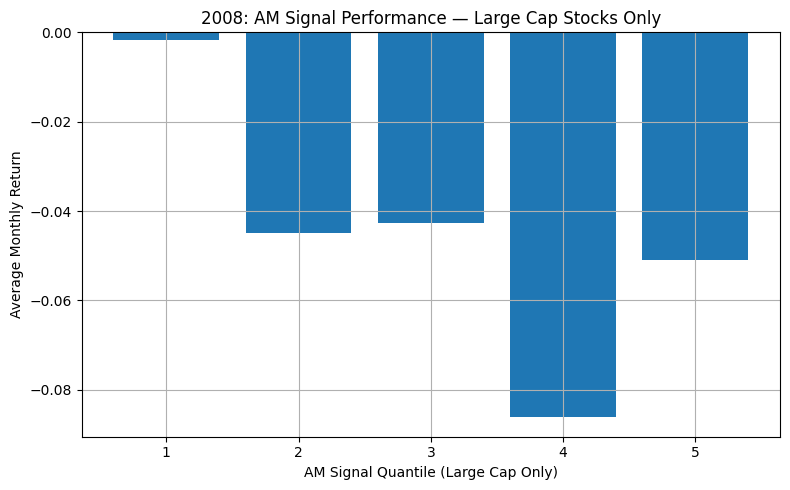

In [45]:
plt.figure(figsize=(8, 5))
plt.bar(avg_returns_large['am_quantile'], avg_returns_large['ret'])
plt.xlabel("AM Signal Quantile (Large Cap Only)")
plt.ylabel("Average Monthly Return")
plt.title("2008: AM Signal Performance — Large Cap Stocks Only")
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.tight_layout()
plt.show()

## What the graph shows 
I looked at just large-cap stocks to see if the AM signal still worked. I grouped the stocks into 5 levels based on their AM score.

The ones with higher scores (especially group 5) lost less money during 2008. So the signal still helped, even in a bad year.

## What I Did

1. Used 2008 signal data to rank stocks each month  
2. Merged in return data  
3. Split stocks into 5 groups based on their signal score  
4. Compared average returns across those groups  
5. Made bar charts to show the results  

## What I Found

- **AM** signal was the most helpful — higher-ranked stocks lost less in 2008  
- **AOP** didn’t show a clear pattern  
- **AnalystRevision** actually did worse — top-ranked stocks had the worst returns  

This shows that some signals can work, but others might not hold up in rough markets like 2008.

## Conclusion

This project shows how you can use data to test stock-picking strategies. It also shows why it’s important to check signals in different types of markets before using them for real investing.
